<h1> Audio Data Augmentation example <h1>

### Imports

In [1]:
from random import randint
import matplotlib.pyplot as plt
import yaml
from crossai.loader import audio_loader

### Load configuration file and dataset path

In [2]:
with open("../config.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
multi_dir_path = config['PATH']['RAW']['MINI_SPEECH_COMMANDS'] # store to dataframe

# All signals are resampled at 22050Hz and normalised (0, 1)
df = audio_loader(multi_dir_path)

Loaded data into the dataframe: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]                                                   


Create crossai audio data object.

In [4]:
from crossai.pipelines.audio import Audio 

In [5]:
# create crossai audio object
cai_audio = Audio(df)
cai_audio.data

0       [0.5122615, 0.51215744, 0.5122032, 0.5121585, ...
1       [0.53833336, 0.5382485, 0.53829324, 0.53825945...
2       [0.59909344, 0.5995758, 0.60014033, 0.5998662,...
3       [0.46179047, 0.45909047, 0.45150578, 0.4502450...
4       [0.5509648, 0.5498947, 0.549121, 0.54910535, 0...
                              ...                        
7995    [0.5364869, 0.5371126, 0.5387156, 0.5392515, 0...
7996    [0.5423568, 0.5426123, 0.5428177, 0.5423651, 0...
7997    [0.49612916, 0.49653575, 0.4966421, 0.4965381,...
7998    [0.4939985, 0.49412805, 0.4942774, 0.49421456,...
7999    [0.5626292, 0.5625252, 0.56263936, 0.5625625, ...
Name: data, Length: 8000, dtype: object

The labels are contained inside audio_object.labels.

In [6]:
cai_audio.labels.head()

0    left
1    left
2    left
3    left
4    left
Name: label, dtype: object

Create augmentations and augmentation order list.

In [7]:
from crossai.processing.augment import roll_signal
from crossai.processing.audio.augment_audio import loudness
from crossai.pipelines.preparation import Augmenter

In [8]:
roll_aug = Augmenter(
    roll_signal,
    augment_times=1,
    n_roll=randint(10000, 50000)
)
loudness_aug = Augmenter(
    loudness,
    augment_times=1,
    factor_low=4,
    factor_high=8
)
Augmentations = [roll_aug, loudness_aug]

Augment data

In [9]:
from crossai.pipelines.preparation import augment_signal_data

cai_audio_augmented = augment_signal_data(cai_audio, Augmentations)

In [10]:
# Augmented Data Lengh: 24000
#   8000 (original) signals
# + 8000 rolled signals (Rolling has been applied for each signal)
# + 8000 loudness changed signals (Loudnes change has been applied for each signal)
# --------
# 24000 samples
cai_audio_augmented.data

0        [0.5122615, 0.51215744, 0.5122032, 0.5121585, ...
1        [0.53833336, 0.5382485, 0.53829324, 0.53825945...
2        [0.59909344, 0.5995758, 0.60014033, 0.5998662,...
3        [0.46179047, 0.45909047, 0.45150578, 0.4502450...
4        [0.5509648, 0.5498947, 0.549121, 0.54910535, 0...
                               ...                        
23995    [0.5364869, 0.5371126, 0.5387156, 0.5392515, 0...
23996    [0.5423568, 0.5426123, 0.5428177, 0.5423651, 0...
23997    [0.49612916, 0.49653575, 0.4966421, 0.4965381,...
23998    [0.4939985, 0.49412805, 0.4942774, 0.49421456,...
23999    [0.5626292, 0.5625252, 0.56263936, 0.5625625, ...
Name: data, Length: 24000, dtype: object

The labels are updated aswell.

In [11]:
cai_audio_augmented.labels

0        left
1        left
2        left
3        left
4        left
         ... 
23995      no
23996      no
23997      no
23998      no
23999      no
Name: label, Length: 24000, dtype: object

<h1>Insertion into processing pipeline example <h1>

Create an audio data to mel spectrograml transformer using create_transformer method.

In [12]:
from crossai.processing.audio import melspectrogram
from crossai.pipelines.timeseries import Transformer

Spectrogram = Transformer(melspectrogram, sr=22050)

Create a processing pipeline that transforms the data into mel spectrograms.

In [13]:
from sklearn.pipeline import Pipeline
from crossai.pipelines.timeseries import ToPandas

pipe = Pipeline([('Spectrogram', Spectrogram), ('ToPandas', ToPandas())])
pipe.fit_transform(cai_audio_augmented)

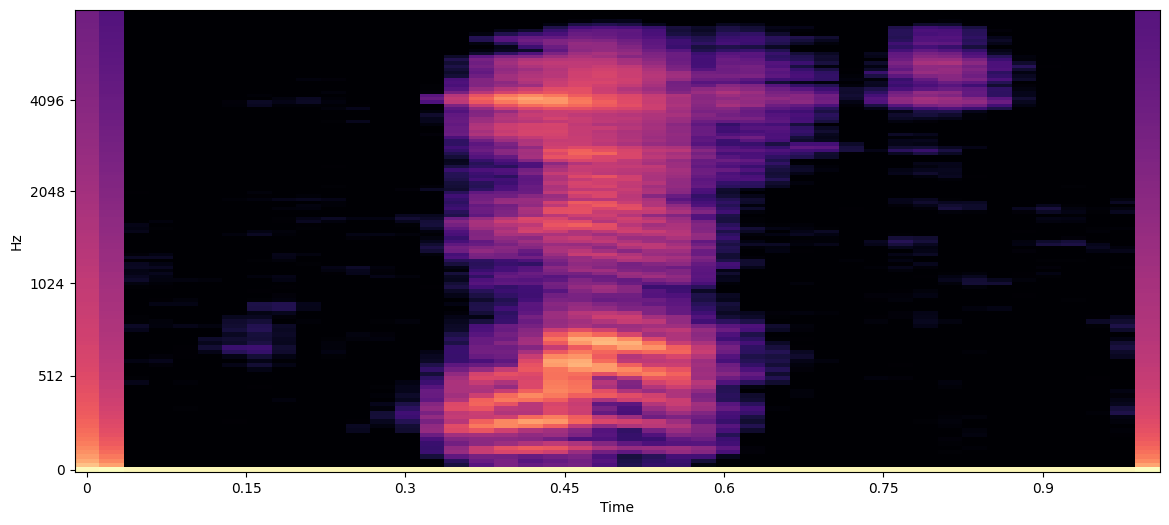

In [14]:
import librosa
import librosa.display
plt.figure(figsize=(14, 6))
librosa.display.specshow(cai_audio_augmented.data[0],
                         x_axis='time',
                         y_axis='mel',
                         fmax=8000)
plt.show()

## 2D Augmentation - SpecAugment 

In [15]:
from crossai.processing.augment import spec_augment
spec = Augmenter(
    spec_augment,
    augment_times=1,
    masks=2,
    freq_masking=0.15,
    time_masking=0.15
)
Augmentations2D = [spec]

cai_audio_spec_augmentned = augment_signal_data(cai_audio_augmented, Augmentations2D)

In [16]:
cai_audio_augmented.data

0        [[-0.6343498, -0.08761597, -0.99645615, -0.996...
1        [[-0.63567734, -0.08831787, -0.9963665, -0.996...
2        [[-0.6350212, -0.08856964, -0.99596405, -0.997...
3        [[-0.64154625, -0.092659, -1.0012989, -1.00260...
4        [[-0.6328125, -0.085948944, -0.994545, -0.9946...
                               ...                        
23995    [[-15.144402, -14.598293, -15.50597, -15.50597...
23996    [[-14.965626, -14.418396, -15.332745, -15.3305...
23997    [[-14.380295, -13.832924, -14.741829, -14.7417...
23998    [[-17.395657, -16.84667, -17.756647, -17.75651...
23999    [[-17.971622, -17.425156, -18.334549, -18.3340...
Length: 24000, dtype: object